## Описание проекта

Существует определенное предприятие, которое занимается обработкой стали и лругих видов. Даны данные по обработке стали с со всеми сопутствующими химическими и физическими процессами. Цель проекта - сократить расходы на электроэнергию : сократить затраты энергии на нагрев стали для термической обработки. Для этог следует разработать модель, которая будет прогнозировать требуемое значение температуры, тем самым сокращаем затраты энергии.

## Пункт 1

Каждый пункт план был выполнен. Была проведена предобрабока данных: были удалены аномалии в данных, был вычислен дополнительный признак - полная мощность и обработаны другие признаки, а также были удалены пропущенные значения в общей таблице данных. Потом было разделение данных на тестовую, тренеровочную и валидационную выборки.

## Пункт 2

Возникли небольшие трудности с выделением целевого признака. Решением данной проблемы было сначала выделение целевой температуры из всей таблицы данных, а после пропущенные значения были удалены. 

## Пункт 3

1 Шаг: Вычитка данных из файлов и исследование их.

2 Шаг: Предобработка данных: выделение целевого признака и других признаков, объединение всех таблицы в один датасет, вычисление дополнительного признака (полной мощности), удаление / исправление аномальных данных и удаление пропущенных значений, разделение данных на тестовую, тренеровочную и валидационную выборки.

3 Шаг: Обучение разных моделей и выбор модель с наилучшим значением метрики MAE.

4 Шаг: Применеие модели на тестовой выборке и получение метрики MAE на тестовых данных. Написание вывода.


## Пункт 4

Итоговая модель - LightGBM. Итоговое значение метрики MAE = 4.311087215557099.

## Исследовательский анализ и предобработка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from catboost import CatBoostRegressor

Здесь добавляю требующиеяся библиотеки для анализа

In [4]:
#data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
#data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
#data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
#data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
#data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
#data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
#data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

На данном шаге делаю вычитку данных из всех файлов

In [3]:
print('Размер выборки', data_arc.shape)
print('Количество дубликатов:', data_arc.duplicated().sum())
print(data_arc.isna().sum())
print(data_arc.info())
#data_arc.head()

Размер выборки (14876, 5)
Количество дубликатов: 0
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [6]:
data_arc.columns = ['key', 'start_heating_arc', 'end_heating_arc', 'active_power', 'reactive_power']
#data_arc.head()

In [5]:
data_arc['start_heating_arc']=pd.to_datetime(data_arc['start_heating_arc'], format='%Y.%m.%d %H:%M:%S')
data_arc['end_heating_arc']=pd.to_datetime(data_arc['end_heating_arc'], format='%Y.%m.%d %H:%M:%S')
data_arc['reactive_power'] = data_arc['reactive_power'].abs()
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                  14876 non-null int64
start_heating_arc    14876 non-null datetime64[ns]
end_heating_arc      14876 non-null datetime64[ns]
active_power         14876 non-null float64
reactive_power       14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Здесь я вывожу данные об электродах. Смотрю на типы данных, объем, пропущенные значения в данной таблице. А также переименую названия колонок и изменяю тип данных двух столбцов со строкового в тип даты и времени.

In [6]:
print(data_bulk.shape)
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 
                    'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_bulk = data_bulk.fillna(0)
print(data_bulk.isna().sum())
print(data_bulk.info())
data_bulk.head()

(3129, 16)
key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
bulk_1     3129 non-null float64
bulk_2     3129 non-null float64
bulk_3     3129 non-null float64
bulk_4     3129 non-null float64
bulk_5     3129 non-null float64
bulk_6     3129 non-null float64
bulk_7     3129 non-null float64
bulk_8     3129 non-null float64
bulk_9     3129 non-null float64
bulk_10    3129 non-null float64
bulk_11    3129 non-null float64
bulk_12    3129 non-null float64
bulk_13    3129 non-null float64
bulk_14    3129 non-null float64
bulk_15    3129 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Теперь я вывожу значения таблицы данных о подаче сыпучих материалов(объем). Смотрю на типы данных и размер таблицы. А также заменяю пропуски в таблице на нули, тем самым это будет означать, что некоторые виды сыпучих материалов не добавлялись.

In [7]:
print(data_bulk_time.shape)
data_bulk_time.columns = ['key', 'bulk_1_time', 'bulk_2_time', 'bulk_3_time', 'bulk_4_time', 'bulk_5_time', 'bulk_6_time', 'bulk_7_time', 'bulk_8_time', 
                    'bulk_9_time', 'bulk_10_time', 'bulk_11_time', 'bulk_12_time', 'bulk_13_time', 'bulk_14_time', 'bulk_15_time']
data_bulk_time['bulk_1_time']=pd.to_datetime(data_bulk_time['bulk_1_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_2_time']=pd.to_datetime(data_bulk_time['bulk_2_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_3_time']=pd.to_datetime(data_bulk_time['bulk_3_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_4_time']=pd.to_datetime(data_bulk_time['bulk_4_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_5_time']=pd.to_datetime(data_bulk_time['bulk_5_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_6_time']=pd.to_datetime(data_bulk_time['bulk_6_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_7_time']=pd.to_datetime(data_bulk_time['bulk_7_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_8_time']=pd.to_datetime(data_bulk_time['bulk_8_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_9_time']=pd.to_datetime(data_bulk_time['bulk_9_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_10_time']=pd.to_datetime(data_bulk_time['bulk_10_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_11_time']=pd.to_datetime(data_bulk_time['bulk_11_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_12_time']=pd.to_datetime(data_bulk_time['bulk_12_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_13_time']=pd.to_datetime(data_bulk_time['bulk_13_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_14_time']=pd.to_datetime(data_bulk_time['bulk_14_time'], format='%Y.%m.%d %H:%M:%S')
data_bulk_time['bulk_15_time']=pd.to_datetime(data_bulk_time['bulk_15_time'], format='%Y.%m.%d %H:%M:%S')

print(data_bulk_time.isna().sum())
print(data_bulk_time.info())
data_bulk_time.head()

(3129, 16)
key                0
bulk_1_time     2877
bulk_2_time     3107
bulk_3_time     1831
bulk_4_time     2115
bulk_5_time     3052
bulk_6_time     2553
bulk_7_time     3104
bulk_8_time     3128
bulk_9_time     3110
bulk_10_time    2953
bulk_11_time    2952
bulk_12_time     679
bulk_13_time    3111
bulk_14_time     323
bulk_15_time     881
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key             3129 non-null int64
bulk_1_time     252 non-null datetime64[ns]
bulk_2_time     22 non-null datetime64[ns]
bulk_3_time     1298 non-null datetime64[ns]
bulk_4_time     1014 non-null datetime64[ns]
bulk_5_time     77 non-null datetime64[ns]
bulk_6_time     576 non-null datetime64[ns]
bulk_7_time     25 non-null datetime64[ns]
bulk_8_time     1 non-null datetime64[ns]
bulk_9_time     19 non-null datetime64[ns]
bulk_10_time    176 non-null datetime64[ns]
bulk_11_time    177 non-null datetime64[ns]
bulk_12_time    2

,key,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_8_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


Здес я делаю вывожу данные о подаче сыпучих материалов(время). Провожу переименование названий колонок. Меняю тип данных со строкового в столбцах в тип даты и времени. А также вывожу размер выборки и количество пропущенных значений.

In [8]:
print(data_gas.shape)
data_gas.columns = ['key', 'gas_1']
print(data_gas.isna().sum())
print(data_gas.info())
data_gas.head()

(3239, 2)
key      0
gas_1    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
gas_1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Теперь вывожу данные о продувке сплава газом. Также смотрю на количество пропущенных значений, типы данных и размер выборки. И делаю переименовку столбцов.

In [9]:
print(data_temp.shape)
data_temp.columns = ['key', 'measurement_time', 'temperature']
data_temp['measurement_time']=pd.to_datetime(data_temp['measurement_time'], format='%Y.%m.%d %H:%M:%S')
print(data_temp.isna().sum())
print(data_temp.info())
data_temp.head()

(15907, 3)
key                    0
measurement_time       0
temperature         2901
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key                 15907 non-null int64
measurement_time    15907 non-null datetime64[ns]
temperature         13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB
None


,key,measurement_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Вывожу результаты измерения температуры в разные моменты времени. Также вывожу размер выборки, пропущенные занчения в столбце температуры могли появится, поскольку датчик мог в те момент некорректно работать и заказчик сказал, что эти данные в дальнейшем можно будет удалить

In [11]:
print(data_wire.shape)
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
data_wire = data_wire.fillna(0.0)
print(data_wire.isna().sum())
print(data_wire.info())
data_wire.head()

(3081, 10)
key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
wire_1    3081 non-null float64
wire_2    3081 non-null float64
wire_3    3081 non-null float64
wire_4    3081 non-null float64
wire_5    3081 non-null float64
wire_6    3081 non-null float64
wire_7    3081 non-null float64
wire_8    3081 non-null float64
wire_9    3081 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Здесь вывожу данные о проволочных материалах (объем). Также делаю вывод размера выборки, заменяю пропущенные значения, что говорит о том, что данный вид проволочного материала не добавляли.

In [12]:
print(data_wire_time.shape)
data_wire_time.columns = ['key', 'wire_1_time', 'wire_2_time', 'wire_3_time', 'wire_4_time', 'wire_5_time', 
                          'wire_6_time', 'wire_7_time', 'wire_8_time', 'wire_9_time']




data_wire_time['wire_1_time']=pd.to_datetime(data_wire_time['wire_1_time'], format='%Y.%m.%d %H:%M:%S')
data_wire_time['wire_2_time']=pd.to_datetime(data_wire_time['wire_2_time'], format='%Y.%m.%d %H:%M:%S')
data_wire_time['wire_3_time']=pd.to_datetime(data_wire_time['wire_3_time'], format='%Y.%m.%d %H:%M:%S')
data_wire_time['wire_4_time']=pd.to_datetime(data_wire_time['wire_4_time'], format='%Y.%m.%d %H:%M:%S')
data_wire_time['wire_5_time']=pd.to_datetime(data_wire_time['wire_5_time'], format='%Y.%m.%d %H:%M:%S')
data_wire_time['wire_6_time']=pd.to_datetime(data_wire_time['wire_6_time'], format='%Y.%m.%d %H:%M:%S')
data_wire_time['wire_7_time']=pd.to_datetime(data_wire_time['wire_7_time'], format='%Y.%m.%d %H:%M:%S')
data_wire_time['wire_8_time']=pd.to_datetime(data_wire_time['wire_8_time'], format='%Y.%m.%d %H:%M:%S')
data_wire_time['wire_9_time']=pd.to_datetime(data_wire_time['wire_9_time'], format='%Y.%m.%d %H:%M:%S')


print(data_wire_time.isna().sum())
print(data_wire_time.info())
data_wire_time.head()

(3081, 10)
key               0
wire_1_time      26
wire_2_time    2002
wire_3_time    3018
wire_4_time    3067
wire_5_time    3080
wire_6_time    3008
wire_7_time    3070
wire_8_time    3062
wire_9_time    3052
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key            3081 non-null int64
wire_1_time    3055 non-null datetime64[ns]
wire_2_time    1079 non-null datetime64[ns]
wire_3_time    63 non-null datetime64[ns]
wire_4_time    14 non-null datetime64[ns]
wire_5_time    1 non-null datetime64[ns]
wire_6_time    73 non-null datetime64[ns]
wire_7_time    11 non-null datetime64[ns]
wire_8_time    19 non-null datetime64[ns]
wire_9_time    29 non-null datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
None


,key,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Здесь я вывел данные о проволочных материалах(время). А также распечатал размер выборки и изменил тип данных у требующихся столбцов. Переименовал названия колонок.

In [13]:
data_pivot1 = data_temp.pivot_table(index ='key', values='measurement_time', aggfunc='last')
time_temp_last = data_pivot1['measurement_time']
time_temp_last.head()

key
1   2019-05-03 11:30:39
2   2019-05-03 11:59:12
3   2019-05-03 12:34:57
4   2019-05-03 12:59:25
5   2019-05-03 13:36:01
Name: measurement_time, dtype: datetime64[ns]

In [14]:
data_temp_last = data_temp.query('measurement_time in @time_temp_last')
print(data_temp_last.shape)
print(data_temp_last.isna().sum())
data_temp_last.columns = ['key', 'measurement_time_last', 'temperature_last']
data_temp_last.head()

(3216, 3)
key                   0
measurement_time      0
temperature         739
dtype: int64


,key,measurement_time_last,temperature_last
4,1,2019-05-03 11:30:39,1613.0
10,2,2019-05-03 11:59:12,1602.0
15,3,2019-05-03 12:34:57,1599.0
18,4,2019-05-03 12:59:25,1625.0
20,5,2019-05-03 13:36:01,1602.0


In [15]:
data_temp_last = data_temp_last.dropna()
print(data_temp_last.shape)
print(data_temp_last.isna().sum())

(2477, 3)
key                      0
measurement_time_last    0
temperature_last         0
dtype: int64


Здесь я выделил целевое значение температуры из всех данных по температуре.

In [16]:
data_pivot2 = data_temp.pivot_table(index ='key', values='measurement_time', aggfunc='first')
time_temp_first = data_pivot2['measurement_time']
time_temp_first.head()

key
1   2019-05-03 11:16:18
2   2019-05-03 11:37:27
3   2019-05-03 12:13:17
4   2019-05-03 12:52:57
5   2019-05-03 13:23:19
Name: measurement_time, dtype: datetime64[ns]

In [17]:
data_temp_first = data_temp.query('measurement_time in @time_temp_first')
print(data_temp_first.shape)
print(data_temp_first.isna().sum())
data_temp_first.columns = ['key', 'measurement_time_first', 'temperature_first']
data_temp_first.head()

(3216, 3)
key                 0
measurement_time    0
temperature         0
dtype: int64


,key,measurement_time_first,temperature_first
0,1,2019-05-03 11:16:18,1571.0
5,2,2019-05-03 11:37:27,1581.0
11,3,2019-05-03 12:13:17,1596.0
16,4,2019-05-03 12:52:57,1601.0
19,5,2019-05-03 13:23:19,1576.0


Здесь я сделал выборку по первоначальным значениям температуры.

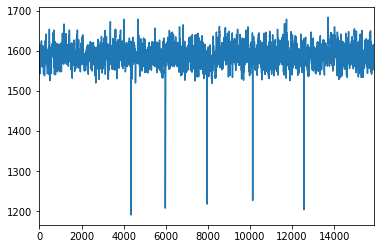

In [18]:
data_temp_first['temperature_first'].plot()

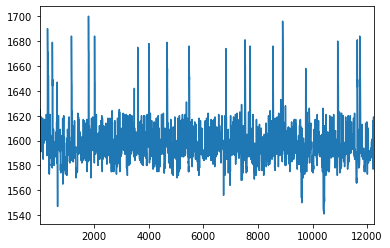

In [19]:
data_temp_last['temperature_last'].plot()

In [20]:
all_data = data_arc
all_data = all_data.merge(data_temp_first, how='outer')
all_data = all_data.merge(data_gas, on=['key'], how='outer')
all_data = all_data.merge(data_bulk, on=['key'], how='outer')
all_data = all_data.merge(data_wire, on=['key'], how='outer')
all_data = all_data.merge(data_temp_last, on=['key'], how='outer' )


print(all_data.shape)
print(all_data.isna().sum())
all_data.head()

(14903, 34)
key                          0
start_heating_arc           27
end_heating_arc             27
active_power                27
reactive_power              27
measurement_time_first      25
temperature_first           25
gas_1                       10
bulk_1                     301
bulk_2                     301
bulk_3                     301
bulk_4                     301
bulk_5                     301
bulk_6                     301
bulk_7                     301
bulk_8                     301
bulk_9                     301
bulk_10                    301
bulk_11                    301
bulk_12                    301
bulk_13                    301
bulk_14                    301
bulk_15                    301
wire_1                     519
wire_2                     519
wire_3                     519
wire_4                     519
wire_5                     519
wire_6                     519
wire_7                     519
wire_8                     519
wire_9                     

,key,start_heating_arc,end_heating_arc,active_power,reactive_power,measurement_time_first,temperature_first,gas_1,bulk_1,bulk_2,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,measurement_time_last,temperature_last
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,2019-05-03 11:16:18,1571.0,29.749986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,2019-05-03 11:16:18,1571.0,29.749986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2019-05-03 11:16:18,1571.0,29.749986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,2019-05-03 11:16:18,1571.0,29.749986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2019-05-03 11:16:18,1571.0,29.749986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0


Теперь я провел объединение всех таблиц в один большой датасет.

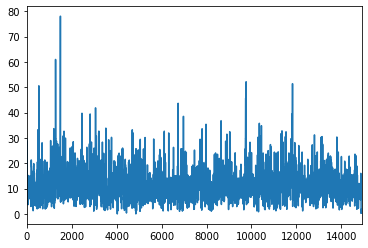

In [21]:
all_data['gas_1'].plot()

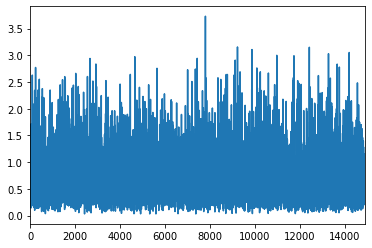

In [22]:
all_data['active_power'].plot()

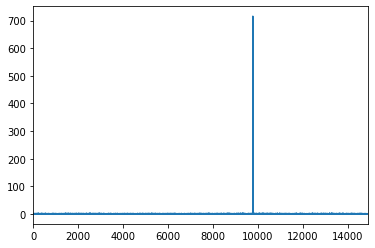

In [23]:
all_data['reactive_power'].plot()

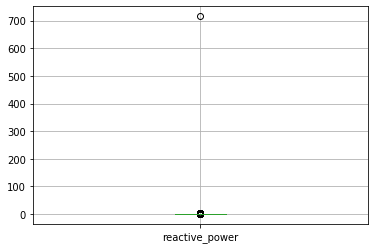

In [24]:
all_data.boxplot(column='reactive_power')

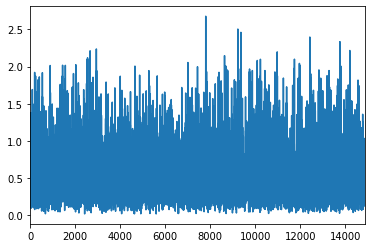

In [25]:
all_data = all_data.query('reactive_power < 10')
all_data['reactive_power'].plot()

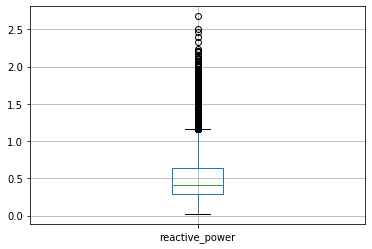

In [26]:
all_data.boxplot(column='reactive_power')

Теперь же аномалия в данных по реактивной мощности не наблюдается

In [27]:
all_data = all_data.dropna()
all_data.isna().sum()

key                       0
start_heating_arc         0
end_heating_arc           0
active_power              0
reactive_power            0
measurement_time_first    0
temperature_first         0
gas_1                     0
bulk_1                    0
bulk_2                    0
bulk_3                    0
bulk_4                    0
bulk_5                    0
bulk_6                    0
bulk_7                    0
bulk_8                    0
bulk_9                    0
bulk_10                   0
bulk_11                   0
bulk_12                   0
bulk_13                   0
bulk_14                   0
bulk_15                   0
wire_1                    0
wire_2                    0
wire_3                    0
wire_4                    0
wire_5                    0
wire_6                    0
wire_7                    0
wire_8                    0
wire_9                    0
measurement_time_last     0
temperature_last          0
dtype: int64

На данном шаге я удаляю все пропущенные значения в датасете, так как их удаление не повлияет сильно на весь датасет.

In [28]:
all_data['full_power'] = (all_data['active_power'] ** 2 + all_data['reactive_power'] ** 2) ** 0.5

In [29]:
all_data.head()

,key,start_heating_arc,end_heating_arc,active_power,reactive_power,measurement_time_first,temperature_first,gas_1,bulk_1,bulk_2,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,measurement_time_last,temperature_last,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,2019-05-03 11:16:18,1571.0,29.749986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,2019-05-03 11:16:18,1571.0,29.749986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2019-05-03 11:16:18,1571.0,29.749986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,2019-05-03 11:16:18,1571.0,29.749986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2019-05-03 11:16:18,1571.0,29.749986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0,0.807239


Здесь я вычесляю полную мощность и добавляю ее к остальным данным.

In [30]:
all_data = all_data.drop(['start_heating_arc', 'end_heating_arc', 'measurement_time_first', 'measurement_time_last'], axis=1)

all_data.head()

,key,active_power,reactive_power,temperature_first,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,temperature_last,full_power
0,1,0.976059,0.687084,1571.0,29.749986,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1613.0,1.193639
1,1,0.805607,0.520285,1571.0,29.749986,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1613.0,0.959010
2,1,0.744363,0.498805,1571.0,29.749986,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1613.0,0.896038
3,1,1.659363,1.062669,1571.0,29.749986,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1613.0,1.970470
4,1,0.692755,0.414397,1571.0,29.749986,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1613.0,0.807239


Теперь я удаляю все колонки, которые содержат дату и время.

# Подготвка данных для обучения моделей

In [31]:
df_1, data_test = train_test_split(all_data, test_size = 0.2, random_state=12345)

features_test = data_test.drop(['temperature_last'], axis=1)
target_test = data_test['temperature_last']
print(features_test.shape)
print(target_test.shape)

(2187, 30)
(2187,)


In [32]:
data_train, data_valid = train_test_split(df_1, test_size=0.2, random_state=12345)

features_train = data_train.drop(['temperature_last'], axis=1)
target_train = data_train['temperature_last']
features_valid = data_valid.drop(['temperature_last'], axis=1)
target_valid = data_valid['temperature_last']

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(6998, 30)
(6998,)
(1750, 30)
(1750,)


Здесь я разбил данные на тестовую, тренеровочную и валидационную выборки, а также выделил целевое значение для них.

## Обучение моделей

### Модель Линейной регрессии

In [33]:
model = LinearRegression()
model.fit(features_train, target_train)
pred_valid = model.predict(features_valid)

mae = mean_absolute_error(pred_valid, target_valid)

print('MAE: ', mae)

MAE:  7.515142925684373


Значение метрики на модели линейной регрессии получилось равным 7.515142925684373.

### Модель Логистической регрессии

In [34]:
model = LogisticRegression()
model.fit(features_train, target_train)
pred_valid = model.predict(features_valid)

mae = mean_absolute_error(pred_valid, target_valid)

print('MAE: ', mae)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


MAE:  7.978285714285715


Значение метрики на модели логистической регрессии регрессии получилось равным 7.978285714285715. 

### Модель LightGBM

In [35]:
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(features_train, target_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [36]:
pred_valid = model_lgb.predict(features_valid)

mae = mean_absolute_error(pred_valid, target_valid)

print('MAE: ', mae)

MAE:  4.18871161880176


Значение метрики на модели логистической регрессии регрессии получилось равным 4.18871161880176. Это значение достаточно низкое, следовательно данную модель можно рассматривать для получения предсказаний на тестовой выборке.

### Модель CatBoost

In [37]:
model_cat = CatBoostRegressor(iterations = 200)
model_cat.fit(features_train, target_train, verbose=50)

pred_valid = model_cat.predict(features_valid)

mae = mean_absolute_error(pred_valid, target_valid)

print('MAE: ', mae)

0:	learn: 11.5961485	total: 51.6ms	remaining: 10.3s
50:	learn: 9.3556803	total: 1.46s	remaining: 4.26s
100:	learn: 8.6312211	total: 2.93s	remaining: 2.87s
150:	learn: 8.2557854	total: 5.01s	remaining: 1.63s
199:	learn: 7.9748576	total: 6.6s	remaining: 0us
MAE:  6.5309172367199695


Значение метрики на модели логистической регрессии регрессии получилось равным 6.5309172367199695. Это значение достаточно низкое, следовательно данную модель можно рассматривать для получения предсказаний на тестовой выборке.

### Вывод:

Самое низкое значение метрики MAE получилось на модели LightGBM равное 3.907133365005662, следовательно на тестовой выборке будем использовать данную модель, также она обучается и делает предсказания быстрее, чем модель CatBoost.

## Оценка качества на тестовой выборке моделью LightGBM

In [38]:
pred_test = model_lgb.predict(features_test)

mae = mean_absolute_error(pred_test, target_test)

print('MAE: ', mae)

MAE:  4.311087215557099


Значение метрики оказалось таким же низким. MAE = 4.311087215557099, следовательно модель LightGBM подходит для предсказания целевого признака в данном проекте. Таким образом, для предсказания температуры в металлургической компании данная модель подходит.